In [1]:
cd home/dataproc

/home/dataproc


In [2]:
import json
from tqdm import tqdm
from time import time
from itertools import product
from typing import List, Tuple, Dict, Any
from collections import defaultdict
from search_backend import SearchMaster
import pickle
import pandas as pd
import concurrent.futures
import numpy as np
from collections import Counter

In [3]:
def average_precision(true_list, predicted_list, k=40):
    true_set = frozenset(true_list)
    predicted_list = predicted_list[:k]
    precisions = []
    for i, (doc_id, _) in enumerate(predicted_list):        
        if doc_id in true_set:
            prec = (len(precisions)+1) / (i+1)            
            precisions.append(prec)
        
    if len(precisions) == 0:
        return 0.0
    return round(sum(precisions)/len(precisions),3)

In [4]:
search_master = SearchMaster()

In [5]:
with open('new_train.json', 'rt') as f:
  queries = json.load(f)

In [6]:
# split queries to train and test
train = list(queries.items())[:int(len(queries) * (2/3))]
test = list(queries.items())[int(len(queries) * (2/3)):]

In [6]:
# params
weights = np.random.uniform(0, 1, (5, 4))
top_n = [10, 15, 20]
max_workers = [2, 8, 16]
min_threshold = [10, 100, 1000]
neighbors = [2, 5, 10, 20]

# Create a list of all possible combinations of parameter settings
param_grid = list(product(weights, top_n, max_workers, min_threshold, neighbors))

In [8]:
def adjust_model(weights, top_n, max_workers, min_threshold, neighbors):
    def expand_query(tokenized_query, pls, index, min_threshold=min_threshold, neighbors=neighbors):       
        query_expansion = []
        for word, pl in pls.items():
            if len(pl) < min_threshold:
                for word, _ in search_master.word_vectors.most_similar(word, topn=neighbors):
                    if word not in tokenized_query:
                        query_expansion.append(word)
        query_expansion, expansion_pls = search_master.get_all_postings(index, query_expansion)
        tokenized_query += query_expansion
        pls.update(expansion_pls)
        return tokenized_query, pls

    search_master.expand_query = expand_query

    def best_search(query, weights=weights, top_n=top_n):
        # get search results
        with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
            jobs = [executor.submit(search_master.binary_search, query, search_master.title_index, expand=True),
                    executor.submit(search_master.bm25_search, query, search_master.stem_body_index, with_stem=True)]

            results = [job.result() for job in jobs]
            results[0] =results[0].most_common(100)
        # merge searchs
        results = search_master.merge(results, weights)
        # return top n results
        return search_master.result_w_title([doc_id for doc_id, score in results[:top_n]])

    search_master.best_search = best_search
    

In [ ]:
result_dict = dict()
best_params = None
best_score = -float('inf')
for i, params in tqdm(enumerate(param_grid)):
    weights, top_n, max_workers, min_threshold, neighbors = params
    adjust_model(*params)

    
    results = []
    times = []
    for query, true_list in train:
        start = time()
        res = search_master.best_search(query)
        total_time = time() - start
        results.append(average_precision(true_list, res)) 
        times.append(total_time)
        
    score=np.mean(results)
    avg_time=np.mean(times)
    print(f'Params: {params}\nmap@40: {score}\nAvg Time: {avg_time}\n')
    
    result_dict[i] = (score, avg_time)
        
    if score > best_score:
        best_score = score
        best_params = params
        
print(best_params)

1it [00:29, 29.19s/it]

Params: (array([0.07472595, 0.86799282, 0.60362071, 0.17747525]), 20, 2, 10, 2)\map@40: 0.48335000000000006
Avg Time: 1.4595978498458861




2it [00:57, 28.91s/it]

Params: (array([0.07472595, 0.86799282, 0.60362071, 0.17747525]), 20, 2, 10, 5)\map@40: 0.46545000000000003
Avg Time: 1.435815703868866




3it [01:27, 29.14s/it]

Params: (array([0.07472595, 0.86799282, 0.60362071, 0.17747525]), 20, 2, 10, 10)\map@40: 0.45185000000000003
Avg Time: 1.4705057501792909




4it [01:57, 29.72s/it]

Params: (array([0.07472595, 0.86799282, 0.60362071, 0.17747525]), 20, 2, 10, 20)\map@40: 0.4487000000000001
Avg Time: 1.530689263343811




5it [02:27, 29.58s/it]

Params: (array([0.07472595, 0.86799282, 0.60362071, 0.17747525]), 20, 2, 100, 2)\map@40: 0.4912000000000001
Avg Time: 1.4661677956581116




6it [02:57, 29.71s/it]

Params: (array([0.07472595, 0.86799282, 0.60362071, 0.17747525]), 20, 2, 100, 5)\map@40: 0.4874500000000001
Avg Time: 1.4978641986846923




7it [03:28, 30.38s/it]

Params: (array([0.07472595, 0.86799282, 0.60362071, 0.17747525]), 20, 2, 100, 10)\map@40: 0.4534000000000001
Avg Time: 1.5881641626358032




8it [04:05, 32.21s/it]

Params: (array([0.07472595, 0.86799282, 0.60362071, 0.17747525]), 20, 2, 100, 20)\map@40: 0.44910000000000017
Avg Time: 1.8058732748031616




9it [04:34, 31.47s/it]

Params: (array([0.07472595, 0.86799282, 0.60362071, 0.17747525]), 20, 2, 1000, 2)\map@40: 0.44010000000000005
Avg Time: 1.4930981993675232




10it [05:08, 32.00s/it]

Params: (array([0.07472595, 0.86799282, 0.60362071, 0.17747525]), 20, 2, 1000, 5)\map@40: 0.46665
Avg Time: 1.6587599277496339




11it [05:47, 34.25s/it]

Params: (array([0.07472595, 0.86799282, 0.60362071, 0.17747525]), 20, 2, 1000, 10)\map@40: 0.45759999999999995
Avg Time: 1.9678535461425781




12it [06:37, 39.16s/it]

Params: (array([0.07472595, 0.86799282, 0.60362071, 0.17747525]), 20, 2, 1000, 20)\map@40: 0.46215
Avg Time: 2.519384443759918




13it [07:06, 35.95s/it]

Params: (array([0.07472595, 0.86799282, 0.60362071, 0.17747525]), 20, 8, 10, 2)\map@40: 0.48335000000000006
Avg Time: 1.4283358097076415




14it [07:34, 33.60s/it]

Params: (array([0.07472595, 0.86799282, 0.60362071, 0.17747525]), 20, 8, 10, 5)\map@40: 0.46545000000000003
Avg Time: 1.4080057501792909




15it [08:03, 32.21s/it]

Params: (array([0.07472595, 0.86799282, 0.60362071, 0.17747525]), 20, 8, 10, 10)\map@40: 0.45185000000000003
Avg Time: 1.4499689936637878




17it [09:04, 31.12s/it]

Params: (array([0.07472595, 0.86799282, 0.60362071, 0.17747525]), 20, 8, 100, 2)\map@40: 0.4912000000000001
Avg Time: 1.444845485687256




18it [09:33, 30.57s/it]

Params: (array([0.07472595, 0.86799282, 0.60362071, 0.17747525]), 20, 8, 100, 5)\map@40: 0.4874500000000001
Avg Time: 1.464959180355072




19it [10:04, 30.68s/it]

Params: (array([0.07472595, 0.86799282, 0.60362071, 0.17747525]), 20, 8, 100, 10)\map@40: 0.4534000000000001
Avg Time: 1.5466716051101685




20it [10:38, 31.79s/it]

Params: (array([0.07472595, 0.86799282, 0.60362071, 0.17747525]), 20, 8, 100, 20)\map@40: 0.44910000000000017
Avg Time: 1.719293463230133




21it [11:08, 31.10s/it]

Params: (array([0.07472595, 0.86799282, 0.60362071, 0.17747525]), 20, 8, 1000, 2)\map@40: 0.44010000000000005
Avg Time: 1.474170732498169




22it [11:40, 31.41s/it]

Params: (array([0.07472595, 0.86799282, 0.60362071, 0.17747525]), 20, 8, 1000, 5)\map@40: 0.46665
Avg Time: 1.6070059537887573




23it [12:17, 33.23s/it]

Params: (array([0.07472595, 0.86799282, 0.60362071, 0.17747525]), 20, 8, 1000, 10)\map@40: 0.45759999999999995
Avg Time: 1.8729564666748046




24it [13:07, 38.12s/it]

Params: (array([0.07472595, 0.86799282, 0.60362071, 0.17747525]), 20, 8, 1000, 20)\map@40: 0.46215
Avg Time: 2.47707998752594




25it [13:35, 35.00s/it]

Params: (array([0.07472595, 0.86799282, 0.60362071, 0.17747525]), 20, 16, 10, 2)\map@40: 0.48335000000000006
Avg Time: 1.3848381638526917




26it [14:03, 32.94s/it]

Params: (array([0.07472595, 0.86799282, 0.60362071, 0.17747525]), 20, 16, 10, 5)\map@40: 0.46545000000000003
Avg Time: 1.4071223974227904




27it [14:31, 31.62s/it]

Params: (array([0.07472595, 0.86799282, 0.60362071, 0.17747525]), 20, 16, 10, 10)\map@40: 0.45185000000000003
Avg Time: 1.4272481203079224




28it [15:01, 31.06s/it]

Params: (array([0.07472595, 0.86799282, 0.60362071, 0.17747525]), 20, 16, 10, 20)\map@40: 0.4487000000000001
Avg Time: 1.4878825068473815




29it [15:30, 30.32s/it]

Params: (array([0.07472595, 0.86799282, 0.60362071, 0.17747525]), 20, 16, 100, 2)\map@40: 0.4912000000000001
Avg Time: 1.4288161993026733




30it [15:59, 29.96s/it]

Params: (array([0.07472595, 0.86799282, 0.60362071, 0.17747525]), 20, 16, 100, 5)\map@40: 0.4874500000000001
Avg Time: 1.4565857887268066




31it [16:30, 30.28s/it]

Params: (array([0.07472595, 0.86799282, 0.60362071, 0.17747525]), 20, 16, 100, 10)\map@40: 0.4534000000000001
Avg Time: 1.550769865512848




32it [17:05, 31.76s/it]

Params: (array([0.07472595, 0.86799282, 0.60362071, 0.17747525]), 20, 16, 100, 20)\map@40: 0.44910000000000017
Avg Time: 1.7604411125183106




33it [17:34, 30.98s/it]

Params: (array([0.07472595, 0.86799282, 0.60362071, 0.17747525]), 20, 16, 1000, 2)\map@40: 0.44010000000000005
Avg Time: 1.4580881476402283




34it [18:07, 31.54s/it]

Params: (array([0.07472595, 0.86799282, 0.60362071, 0.17747525]), 20, 16, 1000, 5)\map@40: 0.46665
Avg Time: 1.6417258977890015




35it [18:44, 33.01s/it]

Params: (array([0.07472595, 0.86799282, 0.60362071, 0.17747525]), 20, 16, 1000, 10)\map@40: 0.45759999999999995
Avg Time: 1.8218944191932678




36it [19:32, 37.67s/it]

Params: (array([0.07472595, 0.86799282, 0.60362071, 0.17747525]), 20, 16, 1000, 20)\map@40: 0.46215
Avg Time: 2.4273187637329103




37it [20:00, 34.78s/it]

Params: (array([0.07472595, 0.86799282, 0.60362071, 0.17747525]), 50, 2, 10, 2)\map@40: 0.41395
Avg Time: 1.4013791918754577




38it [20:28, 32.81s/it]

Params: (array([0.07472595, 0.86799282, 0.60362071, 0.17747525]), 50, 2, 10, 5)\map@40: 0.39985
Avg Time: 1.4101505398750305




39it [20:58, 31.86s/it]

Params: (array([0.07472595, 0.86799282, 0.60362071, 0.17747525]), 50, 2, 10, 10)\map@40: 0.38944999999999996
Avg Time: 1.4829284429550171




40it [21:28, 31.27s/it]

Params: (array([0.07472595, 0.86799282, 0.60362071, 0.17747525]), 50, 2, 10, 20)\map@40: 0.38949999999999996
Avg Time: 1.4946446657180785




41it [21:56, 30.35s/it]

Params: (array([0.07472595, 0.86799282, 0.60362071, 0.17747525]), 50, 2, 100, 2)\map@40: 0.425
Avg Time: 1.4094625949859618




42it [22:26, 30.08s/it]

Params: (array([0.07472595, 0.86799282, 0.60362071, 0.17747525]), 50, 2, 100, 5)\map@40: 0.41269999999999996
Avg Time: 1.4732288718223572




43it [22:57, 30.53s/it]

Params: (array([0.07472595, 0.86799282, 0.60362071, 0.17747525]), 50, 2, 100, 10)\map@40: 0.37870000000000004
Avg Time: 1.5790726780891418




44it [23:33, 31.99s/it]

Params: (array([0.07472595, 0.86799282, 0.60362071, 0.17747525]), 50, 2, 100, 20)\map@40: 0.37745
Avg Time: 1.7692219614982605




45it [24:02, 31.21s/it]

Params: (array([0.07472595, 0.86799282, 0.60362071, 0.17747525]), 50, 2, 1000, 2)\map@40: 0.38285
Avg Time: 1.469114100933075




46it [24:35, 31.65s/it]

Params: (array([0.07472595, 0.86799282, 0.60362071, 0.17747525]), 50, 2, 1000, 5)\map@40: 0.38285
Avg Time: 1.6336932063102723




47it [25:14, 33.96s/it]

Params: (array([0.07472595, 0.86799282, 0.60362071, 0.17747525]), 50, 2, 1000, 10)\map@40: 0.35605
Avg Time: 1.9672263622283936




48it [26:03, 38.44s/it]

Params: (array([0.07472595, 0.86799282, 0.60362071, 0.17747525]), 50, 2, 1000, 20)\map@40: 0.36014999999999997
Avg Time: 2.4447973489761354




49it [26:31, 35.37s/it]

Params: (array([0.07472595, 0.86799282, 0.60362071, 0.17747525]), 50, 8, 10, 2)\map@40: 0.41395
Avg Time: 1.4098634243011474




50it [26:59, 33.30s/it]

Params: (array([0.07472595, 0.86799282, 0.60362071, 0.17747525]), 50, 8, 10, 5)\map@40: 0.39985
Avg Time: 1.4229788422584533




51it [27:30, 32.35s/it]

Params: (array([0.07472595, 0.86799282, 0.60362071, 0.17747525]), 50, 8, 10, 10)\map@40: 0.38944999999999996
Avg Time: 1.5072954773902894




52it [28:00, 31.69s/it]

Params: (array([0.07472595, 0.86799282, 0.60362071, 0.17747525]), 50, 8, 10, 20)\map@40: 0.38949999999999996
Avg Time: 1.507152760028839




53it [28:29, 30.98s/it]

Params: (array([0.07472595, 0.86799282, 0.60362071, 0.17747525]), 50, 8, 100, 2)\map@40: 0.425
Avg Time: 1.466256284713745




54it [29:01, 31.27s/it]

Params: (array([0.07472595, 0.86799282, 0.60362071, 0.17747525]), 50, 8, 100, 5)\map@40: 0.41269999999999996
Avg Time: 1.5968133330345153




55it [29:32, 31.24s/it]

Params: (array([0.07472595, 0.86799282, 0.60362071, 0.17747525]), 50, 8, 100, 10)\map@40: 0.37870000000000004
Avg Time: 1.5581387519836425




56it [30:09, 33.00s/it]

Params: (array([0.07472595, 0.86799282, 0.60362071, 0.17747525]), 50, 8, 100, 20)\map@40: 0.37745
Avg Time: 1.8561595678329468




57it [30:41, 32.48s/it]

Params: (array([0.07472595, 0.86799282, 0.60362071, 0.17747525]), 50, 8, 1000, 2)\map@40: 0.38285
Avg Time: 1.5627346158027648




58it [31:13, 32.58s/it]

Params: (array([0.07472595, 0.86799282, 0.60362071, 0.17747525]), 50, 8, 1000, 5)\map@40: 0.38285
Avg Time: 1.6412116050720216




59it [31:51, 34.00s/it]

Params: (array([0.07472595, 0.86799282, 0.60362071, 0.17747525]), 50, 8, 1000, 10)\map@40: 0.35605
Avg Time: 1.8658796072006225




60it [32:39, 38.20s/it]

Params: (array([0.07472595, 0.86799282, 0.60362071, 0.17747525]), 50, 8, 1000, 20)\map@40: 0.36014999999999997
Avg Time: 2.3995554208755494



60it [32:45, 32.76s/it]


KeyboardInterrupt: 

In [10]:
best_score, best_params

(0.4912000000000001,
 (array([0.07472595, 0.86799282, 0.60362071, 0.17747525]), 20, 2, 100, 2))

In [ ]:
with open('results', 'wb') as f:
    pickle.dump(result_dict)

In [54]:
# params
weights = [[0.1, 0.8, 0.0001, 0.0001],
           [0.01, 0.9, 0.0001, 0.0001],
           [0.01, 0.9, 0.01, 0.001]]

top_n = [10]
min_threshold = [0]
neighbors = [0]

# Create a list of all possible combinations of parameter settings
param_grid = list(product(weights, top_n, min_threshold, neighbors))

In [52]:
def adjust_model(weights, top_n, min_threshold, neighbors):
    def expand_query(tokenized_query, pls, index, min_threshold=min_threshold, neighbors=neighbors):       
        query_expansion = []
        for word, pl in pls.items():
            if len(pl) < min_threshold:
                for word, _ in search_master.word_vectors.most_similar(word, topn=neighbors):
                    if word not in tokenized_query:
                        query_expansion.append(word)
        query_expansion, expansion_pls = search_master.get_all_postings(index, query_expansion)
        tokenized_query += query_expansion
        pls.update(expansion_pls)
        return tokenized_query, pls

    search_master.expand_query = expand_query

    def best_search(query, weights=weights, top_n=top_n):
        # get search results
        with concurrent.futures.ThreadPoolExecutor(max_workers=8) as executor:
            jobs = [executor.submit(search_master.binary_search, query, search_master.title_index, expand=True),
                    executor.submit(search_master.bm25_search, query, search_master.stem_body_index, with_stem=True)]

            results = [job.result() for job in jobs]
            results[0] =results[0].most_common(100)
        # merge searchs
        results = search_master.merge(results, weights)
        # return top n results
        return search_master.result_w_title([doc_id for doc_id, score in results[:top_n]])

    search_master.best_search = best_search
    
    def merge(self, results, weights):
        # Create a dictionary to store the sum of scores for each id
        doc_scores = defaultdict(float)
        for i, result in enumerate(results):
            for id, score in result:
                doc_scores[id] += score * weights[i]

        top_results = dict(sorted(doc_scores.items(), key=itemgetter(1), reverse=True)[:300])

        page_rank = self.page_rank
        page_views = self.page_views
        for doc_id in top_results.keys():
            top_results[doc_id] += weights[-2] * np.log(page_rank.get(doc_id, 0)) + weights[-1] * np.log(page_views.get(doc_id, 0))

        return sorted(top_results.items(), key=itemgetter(1), reverse=True)

In [53]:
result_dict = dict()
best_params = None
best_score = -float('inf')
for i, params in tqdm(enumerate(param_grid)):
    adjust_model(*params)

    
    results = []
    times = []
    for query, true_list in train:
        start = time()
        res = search_master.best_search(query)
        total_time = time() - start
        ap = average_precision(true_list, res)
        results.append(average_precision(true_list, res)) 
        times.append(total_time)
        if ap <= 0.35:
            print(f'bad brediction for query "{query}" (ap = {ap}) for params {params})')
        
    score=np.mean(results)
    avg_time=np.mean(times)
    print(f'Params: {params}\nmap@40: {score}\nAvg Time: {avg_time}\n')
    
    result_dict[i] = (score, avg_time)
        
    if score > best_score:
        best_score = score
        best_params = params
        
print(best_params)


0it [00:00, ?it/s]

bad brediction for query "How do kids come to world?" (ap = 0.1) for params ([0.1, 0.8, 0.0001, 0.0001], 10, 0, 0))
bad brediction for query "Most expensive city in the world" (ap = 0.208) for params ([0.1, 0.8, 0.0001, 0.0001], 10, 0, 0))



1it [00:28, 28.76s/it]

Params: ([0.1, 0.8, 0.0001, 0.0001], 10, 0, 0)
map@40: 0.69445
Avg Time: 1.4380361199378968

bad brediction for query "How do kids come to world?" (ap = 0.1) for params ([0.01, 0.9, 0.0001, 0.0001], 10, 0, 0))
bad brediction for query "Most expensive city in the world" (ap = 0.208) for params ([0.01, 0.9, 0.0001, 0.0001], 10, 0, 0))
bad brediction for query "How do you make gold" (ap = 0.318) for params ([0.01, 0.9, 0.0001, 0.0001], 10, 0, 0))



2it [00:56, 28.23s/it]

Params: ([0.01, 0.9, 0.0001, 0.0001], 10, 0, 0)
map@40: 0.6959500000000001
Avg Time: 1.39297297000885

bad brediction for query "How do kids come to world?" (ap = 0.183) for params ([0.01, 0.9, 0.01, 0.001], 10, 0, 0))
bad brediction for query "How to make wine at home?" (ap = 0.25) for params ([0.01, 0.9, 0.01, 0.001], 10, 0, 0))
bad brediction for query "Most expensive city in the world" (ap = 0.0) for params ([0.01, 0.9, 0.01, 0.001], 10, 0, 0))
bad brediction for query "How to lose weight?" (ap = 0.0) for params ([0.01, 0.9, 0.01, 0.001], 10, 0, 0))
bad brediction for query "Air Jordan" (ap = 0.29) for params ([0.01, 0.9, 0.01, 0.001], 10, 0, 0))
bad brediction for query "how to deal with depression?" (ap = 0.287) for params ([0.01, 0.9, 0.01, 0.001], 10, 0, 0))


3it [01:24, 28.01s/it]

bad brediction for query "How do you make gold" (ap = 0.31) for params ([0.01, 0.9, 0.01, 0.001], 10, 0, 0))
Params: ([0.01, 0.9, 0.01, 0.001], 10, 0, 0)
map@40: 0.56395
Avg Time: 1.3697314620018006

([0.01, 0.9, 0.0001, 0.0001], 10, 0, 0)


In [31]:
#pagerank
max(list(search_master.page_rank.items()), key=lambda x: x[1]), min(list(search_master.page_rank.items()), key=lambda x: x[1])

((3434750, 9913.728782160782), (656, 0.1501208493870428))

In [32]:
#page views
max(list(search_master.page_views.items()), key=lambda x: x[1]), min(list(search_master.page_views.items()), key=lambda x: x[1])

((15580374, 181126232), (59827823, 1))

In [ ]:
#we will add log to merge on page_view and page rank!

# wide compare of methods

In [19]:
# params
weights = [[0.05, 0.9, 0.0001, 0.0001],
           [0.2, 0.9, 0.0001, 0.0001],
           [0.3, 0.9, 0.0001, 0.0001]]

top_n = [10,20]
min_threshold = [100]
neighbors = [2]

# Create a list of all possible combinations of parameter settings
param_grid = list(product(weights, top_n, min_threshold, neighbors))
self = search_master

In [20]:
def adjust_model(weights, top_n, min_threshold, neighbors):
    def expand_query(tokenized_query, pls, index, min_threshold=min_threshold, neighbors=neighbors):       
        query_expansion = []
        for word, pl in pls.items():
            if len(pl) < min_threshold:
                for word, _ in search_master.word_vectors.most_similar(word, topn=neighbors):
                    if word not in tokenized_query:
                        query_expansion.append(word)
        query_expansion, expansion_pls = search_master.get_all_postings(index, query_expansion)
        tokenized_query += query_expansion
        pls.update(expansion_pls)
        return tokenized_query, pls

    search_master.expand_query = expand_query

    def best_search(query, weights=weights, top_n=top_n):
        # get search results
        with concurrent.futures.ThreadPoolExecutor(max_workers=8) as executor:
            jobs = [executor.submit(search_master.binary_search, query, search_master.stem_title_index, with_stem=True, expand=True),
                    executor.submit(search_master.bm25_search, query, search_master.stem_body_index, 
                                    search_master.doc_length, with_stem=True, expand=True)]

            results = [job.result() for job in jobs]
            results[0] =results[0].most_common(100)
        # merge searchs
        results = search_master.merge(results, weights)
        # return top n results
        return search_master.result_w_title([doc_id for doc_id, score in results[:top_n]])

    search_master.best_search = best_search
    
    def merge(self, results, weights):
        # Create a dictionary to store the sum of scores for each id
        doc_scores = defaultdict(float)
        for i, result in enumerate(results):
            for id, score in result:
                doc_scores[id] += score * weights[i]

        top_results = dict(sorted(doc_scores.items(), key=itemgetter(1), reverse=True)[:300])

        page_rank = self.page_rank
        page_views = self.page_views
        for doc_id in top_results.keys():
            top_results[doc_id] += weights[-2] * np.log(page_rank.get(doc_id, 1)) + weights[-1] * np.log(page_views.get(doc_id, 1))

        return sorted(top_results.items(), key=itemgetter(1), reverse=True)

In [43]:
result_dict = dict()
best_params = None
best_score = -float('inf')
for i, params in tqdm(enumerate(param_grid)):
    adjust_model(*params)

    
    results = []
    times = []
    for query, true_list in train:
        start = time()
        res = search_master.best_search(query)
        total_time = time() - start
        ap = average_precision(true_list, res)
        results.append(average_precision(true_list, res)) 
        times.append(total_time)
        if ap <= 0.35:
            print(f'bad brediction for query "{query}" (ap = {ap}) for params {params})')
        
    score=np.mean(results)
    avg_time=np.mean(times)
    print(f'Params: {params}\nmap@40: {score}\nAvg Time: {avg_time}\n')
    
    result_dict[i] = (score, avg_time)
        
    if score > best_score:
        best_score = score
        best_params = params
        
print(best_params)


0it [00:00, ?it/s]

bad brediction for query "How do kids come to world?" (ap = 0.1) for params ([0.05, 0.9, 0.0001, 0.0001], 10, 100, 2))
bad brediction for query "Most expensive city in the world" (ap = 0.243) for params ([0.05, 0.9, 0.0001, 0.0001], 10, 100, 2))



1it [00:28, 28.09s/it]

bad brediction for query "How do you make gold" (ap = 0.318) for params ([0.05, 0.9, 0.0001, 0.0001], 10, 100, 2))
Params: ([0.05, 0.9, 0.0001, 0.0001], 10, 100, 2)
map@40: 0.7054
Avg Time: 1.404484796524048

bad brediction for query "How do kids come to world?" (ap = 0.1) for params ([0.05, 0.9, 0.0001, 0.0001], 20, 100, 2))
bad brediction for query "Most expensive city in the world" (ap = 0.243) for params ([0.05, 0.9, 0.0001, 0.0001], 20, 100, 2))



2it [00:56, 28.31s/it]

bad brediction for query "How do you make gold" (ap = 0.345) for params ([0.05, 0.9, 0.0001, 0.0001], 20, 100, 2))
Params: ([0.05, 0.9, 0.0001, 0.0001], 20, 100, 2)
map@40: 0.6976500000000001
Avg Time: 1.4225597023963927

bad brediction for query "How do kids come to world?" (ap = 0.1) for params ([0.2, 0.9, 0.0001, 0.0001], 10, 100, 2))
bad brediction for query "Most expensive city in the world" (ap = 0.243) for params ([0.2, 0.9, 0.0001, 0.0001], 10, 100, 2))



3it [01:25, 28.46s/it]

bad brediction for query "How do you make gold" (ap = 0.318) for params ([0.2, 0.9, 0.0001, 0.0001], 10, 100, 2))
Params: ([0.2, 0.9, 0.0001, 0.0001], 10, 100, 2)
map@40: 0.7021
Avg Time: 1.4314425706863403

bad brediction for query "How do kids come to world?" (ap = 0.1) for params ([0.2, 0.9, 0.0001, 0.0001], 20, 100, 2))
bad brediction for query "Most expensive city in the world" (ap = 0.243) for params ([0.2, 0.9, 0.0001, 0.0001], 20, 100, 2))



4it [01:53, 28.29s/it]

bad brediction for query "How do you make gold" (ap = 0.345) for params ([0.2, 0.9, 0.0001, 0.0001], 20, 100, 2))
Params: ([0.2, 0.9, 0.0001, 0.0001], 20, 100, 2)
map@40: 0.6938500000000001
Avg Time: 1.401330554485321

bad brediction for query "How do kids come to world?" (ap = 0.0) for params ([0.3, 0.9, 0.0001, 0.0001], 10, 100, 2))
bad brediction for query "Most expensive city in the world" (ap = 0.243) for params ([0.3, 0.9, 0.0001, 0.0001], 10, 100, 2))



5it [02:21, 28.27s/it]

bad brediction for query "How do you make gold" (ap = 0.339) for params ([0.3, 0.9, 0.0001, 0.0001], 10, 100, 2))
Params: ([0.3, 0.9, 0.0001, 0.0001], 10, 100, 2)
map@40: 0.6944000000000001
Avg Time: 1.4112839937210082

bad brediction for query "How do kids come to world?" (ap = 0.091) for params ([0.3, 0.9, 0.0001, 0.0001], 20, 100, 2))
bad brediction for query "Most expensive city in the world" (ap = 0.243) for params ([0.3, 0.9, 0.0001, 0.0001], 20, 100, 2))


6it [02:49, 28.30s/it]

Params: ([0.3, 0.9, 0.0001, 0.0001], 20, 100, 2)
map@40: 0.6911999999999999
Avg Time: 1.4183302879333497

([0.05, 0.9, 0.0001, 0.0001], 10, 100, 2)


In [21]:
from math import log, sqrt
def tfidf_vectors(inverted_index: Dict[str, List[Tuple[int, int]]],
                  df: Dict[str, int],
                  Q: List[str],
                  DL: Dict[int, int]) -> Tuple[Dict[str, float], Dict[int, Dict[str, float]]]:
    N = len(DL)
    query_vec = {}
    doc_vecs = {}
    # calculate the tf-idf score for each word in the query
    for word in Q:
        tf = Q.count(word) / len(Q)
        idf = log(N/df[word]) #.get(word, 1))
        query_vec[word] = tf * idf
    # Only calculate the tf-idf score for each word in the document if it's in the query
    for word in Q:
        for doc_id, tf in inverted_index.get(word, []):
            if doc_id not in doc_vecs:
                doc_vecs[doc_id] = {}
            try:
                tf_norm = tf / DL[doc_id]
                idf = log(N/df[word])
            except ZeroDivisionError:
                raise ZeroDivisionError(f'{doc_id} not found for word "{word}"')
            doc_vecs[doc_id][word] = tf_norm * idf
    return query_vec, doc_vecs

def cosine_similarity(vec1: Dict[str, float], vec2: Dict[str, float]) -> float:
    """
    Compute the cosine similarity between two vectors
    """
    dot_product = sum(vec1.get(word, 0) * vec2.get(word, 0) for word in set(vec1.keys()).union(vec2.keys()))
    norm1 = sqrt(sum(val ** 2 for val in vec1.values()))
    norm2 = sqrt(sum(val ** 2 for val in vec2.values()))
    return dot_product / (norm1 * norm2)

def tfidf(inverted_index: Dict[str, List[Tuple[int, int]]],
           df: Dict[str, int],
           Q: List[str],
           DL: Dict[int, int],
           limit=100) -> List[Tuple[int, float]]:
    query_vec, doc_vecs = tfidf_vectors(inverted_index, df, Q, DL)
    # compute the similarity between the query and each document
    similarities = [(doc_id, cosine_similarity(query_vec, doc_vec)) for doc_id, doc_vec in doc_vecs.items()]
    # sort the similarities in descending order and return the top 100 closest documents
    similarities = sorted(similarities, key=lambda x: x[1], reverse=True)
    return similarities[:limit]

In [22]:
def tfidf_search(query, index, DL, n_results=100, with_stem=False):
    # tokenize query
    tokenized_query = search_master.tokenize(query, with_stem)
    # get top 100 results
    tokenized_query, pls = search_master.get_all_postings(index, tokenized_query)
    top_n = tfidf(inverted_index=pls,
                               df=index.df, 
                               Q=tokenized_query,
                               DL=DL,
                               limit=n_results)
    
    return top_n
    
search_master.tfidf_search =tfidf_search

def bm25(inverted_index: Dict[str, List[Tuple[int, int]]],
                df: Dict[str, int],
                Q: List[str],
                DL: Dict[int, int],
                avdl: float,
                N: int,
                k1=1.2, b=0.75, limit=100) -> Dict[int,float]:

    scores = Counter()
    for word in Q:
        for doc_id, tf in inverted_index.get(word, []):
            dl = DL[doc_id]
            n = df[word]
            tf_weight = ( (k1+1) * tf ) / ( k1 * ( (1-b) + b * dl / avdl ) + tf )
            idf_weight = log( (N-n+0.5) / (n+0.5) )
            scores[doc_id] += tf_weight * idf_weight

    return scores.most_common(limit)

In [23]:

def bm25_search(query, index, DL, n_results=100, with_stem=False, expand=False):
    # tokenize query
    tokenized_query = self.tokenize(query, with_stem)
    tokenized_query, pls = self.get_all_postings(index, tokenized_query)

    if expand:
        tokenized_query, pls = self.expand_query(tokenized_query, pls, index)
        
    top_n = bm25(inverted_index=pls,
                               df=index.df, 
                               Q=tokenized_query,
                               DL=DL,
                               avdl= self.avdl,
                               N = self.N,
                               limit=n_results)

    return top_n
search_master.bm25_search = bm25_search

In [7]:
self = search_master
def all_search_results(query, n=100):
    title_DL={doc_id:len(title) for doc_id, title in self.titles.items()}
    text_DL=self.doc_length
    # for testing
    search_scores = dict()
    search_scores['binary_title_weight']=self.binary_search(query, self.title_index).most_common(n)
    search_scores['binary_anchor_weight']=self.binary_search(query, self.anchor_index).most_common(n)
    search_scores['binary_body_weight']=self.binary_search(query, self.body_index).most_common(n)
    search_scores['stem_binary_title_weight']=self.binary_search(query, self.stem_title_index, with_stem=True).most_common(n)
    search_scores['stem_binary_body_weight']=self.binary_search(query, self.stem_body_index, with_stem=True).most_common(n)
    search_scores['tfidf_text_weight']=self.tfidf_search(query, self.body_index, text_DL)
    search_scores['tfidf_title_weight']=self.tfidf_search(query, self.title_index, title_DL)
    search_scores['bm25_title_score']=self.bm25_search(query, self.title_index, title_DL)
    search_scores['bm25_title_stem_score']=self.bm25_search(query, self.stem_title_index, title_DL, with_stem=True)
    search_scores['bm25_text_score']=self.bm25_search(query, self.body_index, text_DL)
    search_scores['bm25_text_stem_score']=self.bm25_search(query, self.stem_body_index, text_DL, with_stem=True)
    return search_scores

search_master.all_search_results =all_search_results

In [8]:
results = {query:search_master.all_search_results(query) for query, _ in train}

In [9]:
def average_precision(true_list, predicted_list, k=40):
    true_set = frozenset(true_list)
    predicted_list = predicted_list[:k]
    precisions = []
    for i, (doc_id, _) in enumerate(predicted_list):        
        if doc_id in true_set:
            prec = (len(precisions)+1) / (i+1)            
            precisions.append(prec)
        if i == 20:
            break
        
    if len(precisions) == 0:
        return 0.0
    return round(sum(precisions)/len(precisions),3)

In [10]:
acc_results = dict()
for query, result in results.items():
    method_acc = dict()
    for method_name, prediction in result.items():
        method_acc[method_name] = average_precision(queries[query], prediction)

    acc_results[query] = method_acc       

In [11]:
pd.options.display.float_format = '{:,.2f}'.format
df = pd.DataFrame(acc_results)
df = df.drop(['how to make money fast?', 'LinkedIn','Information retrieval', 'Ritalin', 'Java', 'Netflix', 'Air Jordan', 'Apple computer'], axis=1)
df['MAP@40'] = df.mean(axis=1)
df.style.background_gradient(cmap='Blues').set_precision(2).set_table_attributes("title='Query Performance'")

,best marvel movie,How do kids come to world?,How to make coffee?,How to make wine at home?,Most expensive city in the world,India,The Simpsons,World cup,How to lose weight?,how to deal with depression?,How do you make gold,Marijuana,MAP@40
binary_title_weight,0.00,0.05,0.32,0.00,0.25,0.37,0.77,0.86,0.00,0.00,0.58,0.56,0.31
binary_anchor_weight,0.00,0.00,0.00,0.00,0.23,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.10
binary_body_weight,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
stem_binary_title_weight,0.00,0.07,0.29,0.00,0.25,0.37,0.50,0.86,1.00,0.00,0.50,0.56,0.37
stem_binary_body_weight,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
tfidf_text_weight,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
tfidf_title_weight,0.00,0.10,0.31,0.00,0.62,0.37,0.77,0.78,0.00,0.08,0.00,0.56,0.30
bm25_title_score,0.00,0.11,0.17,0.00,1.00,0.15,0.64,0.00,0.00,0.00,0.00,0.21,0.19
bm25_title_stem_score,0.00,0.00,0.15,0.07,1.00,0.15,0.00,0.00,0.50,0.00,0.00,0.21,0.17
bm25_text_score,0.05,0.00,0.12,0.13,0.00,0.12,0.09,0.00,0.56,0.12,0.00,0.36,0.13


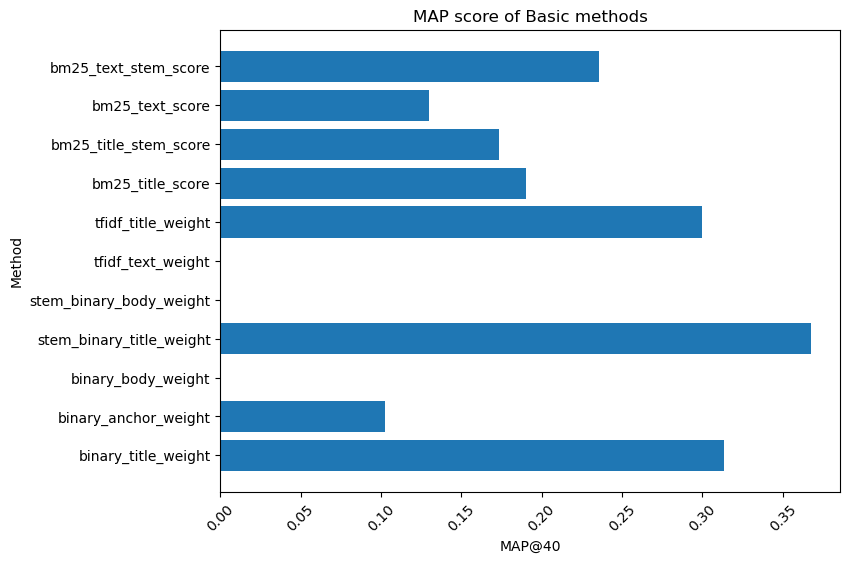

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.barh(df.index, df['MAP@40'])
plt.xlabel('MAP@40')
plt.ylabel('Method')
plt.title('MAP score of Basic methods')
plt.xticks(rotation=45)
plt.show()

## validate

In [128]:
from operator import itemgetter
self =search_master
def adjust_model(weights=[0.01, 0.01, 0.0001, 1], top_n=10):
    def normalize_result(scores):
        normalized = []
        if scores:
            max_value = max(scores, key=lambda x: x[1])[1]
            normalized = [(key, value/max_value) for key, value in scores]
        return normalized

    def best_search(query, weights=weights, top_n=top_n):
        # get search results
        with concurrent.futures.ThreadPoolExecutor(max_workers=8) as executor:
            jobs = [executor.submit(search_master.binary_search, query, search_master.stem_title_index, with_stem=True, expand=True),
                    executor.submit(search_master.bm25_search, query, search_master.stem_body_index, 
                                    search_master.doc_length, with_stem=True, expand=True)]

            results = [job.result() for job in jobs]
            results[0] =results[0].most_common(20)
            results = [normalize_result(res[:20]) for res in results]
        # merge searchs
        results = search_master.merge(results, weights)
        # return top n results
        return search_master.result_w_title([doc_id for doc_id, score in results[:top_n]])

    search_master.best_search = best_search
    
    def merge(results, weights):
        # Create a dictionary to store the sum of scores for each id
        doc_scores = defaultdict(float)
        for i, result in enumerate(results):
            for id, score in result:
                doc_scores[id] += score * weights[i]

        top_results = dict(sorted(doc_scores.items(), key=itemgetter(1), reverse=True)[:150])

        page_rank = self.page_rank
        page_views = self.page_views
        for doc_id in top_results.keys():
            top_results[doc_id] += weights[-2] * page_rank.get(doc_id, 1) + weights[-1] * page_views.get(doc_id, 1)

        return sorted(top_results.items(), key=itemgetter(1), reverse=True)
    
    search_master.merge = merge

In [7]:

results = []
times = []
for query, true_list in queries.items():
    start = time()
    res = search_master.best_search(query)
    total_time = time() - start
    ap = average_precision(true_list, res)
    results.append(average_precision(true_list, res)) 
    times.append(total_time)
    if ap <= 0.35:
        print(f'bad Prediction for query "{query}" (ap = {ap}))')
    elif ap >= 0.95:
        print(f'good Prediction for query "{query}" (ap = {ap}))')
        
        

score=np.mean(results)
avg_time=np.mean(times)
print(f'map@40: {score}\nAvg Time: {avg_time}\n')
    


good Prediction for query "best marvel movie" (ap = 1.0))
good Prediction for query "How do kids come to world?" (ap = 1.0))
good Prediction for query "Information retrieval" (ap = 1.0))
good Prediction for query "LinkedIn" (ap = 1.0))
bad brediction for query "How to make wine at home?" (ap = 0.0))
bad brediction for query "Most expensive city in the world" (ap = 0.294))
good Prediction for query "Java" (ap = 1.0))
bad brediction for query "how to deal with depression?" (ap = 0.0))
bad brediction for query "How do you make gold" (ap = 0.183))
good Prediction for query "How to make hummus" (ap = 1.0))
good Prediction for query "Natural Language processing" (ap = 1.0))
good Prediction for query "World Cup 2022" (ap = 1.0))
good Prediction for query "Dolly the sheep" (ap = 0.963))
bad brediction for query "Ciggarets" (ap = 0.0))
bad brediction for query "What is the best place to live in?" (ap = 0.0))
bad brediction for query "How do you breed flowers?" (ap = 0.2))
map@40: 0.698333333333

In [7]:
# quality check
self =search_master

def quality(query, weights=[0.01, 0.01, 0.0001, 1], top_n=10):
    # get search results
    with concurrent.futures.ThreadPoolExecutor(max_workers=8) as executor:
        jobs = [executor.submit(search_master.binary_search, query, search_master.stem_title_index, with_stem=True, expand=True),
                executor.submit(search_master.bm25_search, query, search_master.stem_body_index, 
                                search_master.doc_length, with_stem=True, expand=True)]

        results = [job.result() for job in jobs]
        results[0] =results[0].most_common(20)
        results = [self.normalize_result(res[:20]) for res in results]
    # merge searchs
    best = search_master.merge(results, weights)
    # return top n results
    results = [dict(res) for res in results]
    info = dict()
    for doc_id, score in best:
        binary = results[0].get(doc_id, 0)
        bm25 = results[1].get(doc_id, 0)
        title =  self.titles[doc_id]
        pv = self.page_views[doc_id]
        pr = self.page_rank[doc_id]
        info[title] = {'binary score':binary, 'bm25 score':bm25, 'page_views':int(pv*181126232), 'page rank':pr*9913, 'total score':score*100}
    return info  
self.quality = quality


In [8]:
# bad
query = 'How to make wine at home?'
info = search_master.quality(query)

df= pd.DataFrame(info).T
df.head(15).style.background_gradient(cmap='Blues').set_precision(3)

,binary score,bm25 score,page_views,page rank,total score
Making it Home with Kortney and Kenny,1.000,0.000,54027.000,0.200,1.030
"Just what is it that makes today's homes so different, so appealing?",1.000,0.000,1831.000,0.611,1.001
"If an Angel Came to See You, Would You Make Her Feel at Home?",1.000,0.000,430.000,0.218,1.000
Making Home Affordable,1.000,0.000,373.000,1.181,1.000
The Ones That Didn't Make It Back Home,1.000,0.000,331.000,0.234,1.000
Don't It Make You Want to Go Home,1.000,0.000,227.000,0.312,1.000
List of Last of the Summer Wine home video releases,1.000,0.000,167.000,0.150,1.000
The Make Yourself at Home EP,1.000,0.000,157.000,0.296,1.000
Make Sure You're Home for Christmas,1.000,0.000,97.000,0.193,1.000
Matt Kramer (wine writer),0.000,1.000,77.000,0.640,1.000


In [9]:
# good
query = 'Information retrieval'
info = search_master.quality(query)

df= pd.DataFrame(info).T
df.head(15).style.background_gradient(cmap='Blues').set_precision(3)

,binary score,bm25 score,page_views,page rank,total score
Information retrieval,1.000,0.990,12510.000,34.360,1.997
Cross-language information retrieval,1.000,0.993,333.000,1.468,1.993
Relevance (information retrieval),1.000,0.974,2050.000,4.453,1.975
Information Retrieval Specialist Group,1.000,0.973,6.000,0.215,1.973
Information Retrieval Facility,1.000,0.970,24.000,0.223,1.970
Special Interest Group on Information Retrieval,1.000,0.952,110.000,1.908,1.952
Human–computer information retrieval,1.000,0.952,145.000,0.580,1.952
Music information retrieval,1.000,0.000,1464.000,3.552,1.001
Boolean model of information retrieval,1.000,0.000,1377.000,0.540,1.001
Ranking (information retrieval),1.000,0.000,1171.000,1.850,1.001


In [39]:
time_search = dict()
self= search_master
engines = {'page rank':self.get_pagerank, 'page view':self.get_pageviews, 'search title':self.get_relevant_titles, 'search anchor':self.get_relevant_anchors, 'search body':self.get_relevant_bodies, 'search':self.best_search}
for name, test in list(engines.items())[2:]:
    start = time()
    for (query, _) in queries.items():
        res = test(query)
        
    time_search[name]= (time()-start) / 30

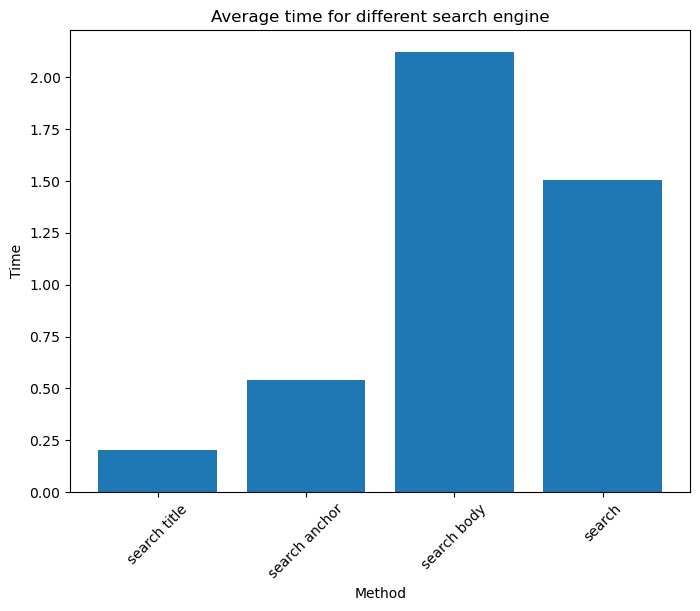

In [41]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
D = time_search
plt.bar(range(len(D)), list(D.values()), align='center')
plt.xticks(range(len(D)), list(D.keys()))
plt.ylabel('Time')
plt.xlabel('Method')
plt.title('Average time for different search engine')
plt.xticks(rotation=45)
plt.show()

### grid search best methods

### Page rank and Page view

In [ ]:
wiki_ids = []

In [ ]:
res = requests.post(url + '/get_pagerank', json=wiki_ids, timeout=35)
if res.status_code == 200:
    res.json()

In [ ]:
res = requests.post(url + '/get_pagerank', json=wiki_ids, timeout=35)
if res.status_code == 200:
    res.json()